# Convolutional Neural Network

Simple feedforward multilayer convolutional neural network implemented in Tensorflow

## Load digits dataset

In [1]:
from sklearn import datasets

In [2]:
digits = datasets.load_digits()
data = digits.data
labels = digits.target
data.shape, labels.shape

((1797, 64), (1797,))

## Convert labels into one-hot vectors

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
one_hot = OneHotEncoder(sparse=False, dtype=int)
labels = labels.reshape(-1, 1) # convert (n,) -> (n,1)
labels = one_hot.fit_transform(labels)

## Split into training and test sets

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [7]:
x_dim = X_train.shape[1]
y_dim = y_train.shape[1]

x_width = x_height = np.sqrt(x_dim).astype(int)
(x_dim, y_dim), (x_width, x_height)

((64, 10), (8, 8))

## Build the model

In [8]:
import tensorflow as tf

In [9]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01, name='W')
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape, name='b')
    return tf.Variable(initial)

# TF uses 'NHWC' format to represent 4d tensors: batch_size, height, width, n_channels
# This is why 'strides' and 'ksize' have 4 dimensions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name='conv')

def max_pool_2x2(x):
    # 2x2 windows with 2px stride
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='max_pool')

create input nodes

In [10]:
with tf.name_scope('input'):
    X = tf.placeholder(tf.float32, [None, x_dim], name='X')
    y = tf.placeholder(tf.float32, [None, y_dim], name='y')
    X_4d = tf.reshape(X, [-1, x_height, x_width, 1], name='X_4d')

create first layer

In [11]:
with tf.name_scope('conv1'):
    W1 = weight_variable([3, 3, 1, 16])
    b1 = bias_variable([16])
    
    conv1 = conv2d(X_4d, W1) + b1
    relu1 = tf.nn.relu(conv1, name='relu')
    h1 = max_pool_2x2(relu1)

create second layer

In [12]:
with tf.name_scope('conv2'):
    W2 = weight_variable([3, 3, 16, 32])
    b2 = bias_variable([32])
    
    conv2 = conv2d(h1, W2) + b2
    relu2 = tf.nn.relu(conv2, name='relu')
    h2 = max_pool_2x2(relu2)

create fully-connected layer

In [13]:
with tf.name_scope('fc1'):
    W3 = weight_variable([2*2*32, 512])
    b3 = bias_variable([512])
    
    h2_1d = tf.reshape(h2, [-1, 2*2*32])
    a3 = tf.matmul(h2_1d, W3) + b3
    h3 = tf.nn.relu(a3)

apply dropout

In [14]:
keep_prob = tf.placeholder(tf.float32)
h3_drop = tf.nn.dropout(h3, keep_prob, name='dropout')

create softmax translation layer

In [15]:
with tf.name_scope('fc2'):
    W4 = weight_variable([512, 10])
    b4 = bias_variable([10])

    y_out = tf.matmul(h3_drop, W4) + b4

create loss

In [16]:
with tf.name_scope('loss'):
    softmax = tf.nn.softmax_cross_entropy_with_logits(y_out, y, name='softmax')
    loss = tf.reduce_mean(softmax, name='mean')

create gradient for softmax

In [17]:
with tf.name_scope('softmax_grad'):
    softmax_grad = tf.gradients(softmax, X)

create optimizer

In [18]:
with tf.name_scope('trainer'):
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss, global_step=global_step)

create evaluation nodes

In [19]:
with tf.name_scope('evaluation'):
    correct_prediction = tf.equal(tf.argmax(y_out,1), tf.argmax(y,1), 'correct')
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

create debug (summary) nodes

In [20]:
with tf.name_scope('summary'):
    tf.scalar_summary('loss', loss)
    tf.scalar_summary('accuracy', accuracy)
    w_hist = tf.histogram_summary('W4', W4)
    b_hist = tf.histogram_summary('b4', b4)
    summaries = tf.merge_all_summaries()

In [21]:
with tf.name_scope('visualizer') as scope:
    # Build 4x4 grid to visualize 16 filters of W1 [3, 3, 1, 16]
    W1_slices = tf.split(split_dim=3, num_split=16, value=W1) # 16 x [3, 3, 1, 1]
    rows = []
    n_cols = n_rows = 4
    for start in range(0, 16, n_cols):
        end = start + n_cols
        r = tf.concat(0, W1_slices[start:end]) # [4*3, 3, 1, 1]
        rows.append(r)
    W1_img = tf.concat(1, rows) # [4*3, 4*3, 1, 1]
    W1_img = tf.reshape(W1_img, [1, 12, 12, 1])

    epoch = tf.placeholder(tf.string, None, name='epoch')
    img_summary = tf.image_summary(epoch, W1_img, max_images=100)

In [22]:
with tf.name_scope('init'):
    init_op = tf.initialize_all_variables()

## Train the model

In [23]:
from tqdm import tqdm

In [24]:
!rm -rf ./logs

In [25]:
summary_writer = tf.train.SummaryWriter('./logs/cnn')

In [26]:
batch_size = 100
n_epochs = 800
# with tf.Session() as sess:
sess = tf.Session()
summary_writer.add_graph(sess.graph)
sess.run(init_op) # init all variables
for e in tqdm(range(n_epochs)):
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size
        batch = {X: X_train[start:end], y: y_train[start:end], keep_prob: 0.5}
        sess.run(train_step, feed_dict=batch)

    summary_val = sess.run(summaries, feed_dict={X: X_test, y: y_test, keep_prob: 1.0})
    summary_writer.add_summary(summary_val, e)

    if e % 100 == 0:
        summary_val = sess.run(img_summary, feed_dict={epoch: 'epoch%d' % e})
        summary_writer.add_summary(summary_val, e)

    summary_writer.flush()
acc = sess.run(accuracy, feed_dict={X: X_test, y: y_test, keep_prob: 1.0})
print('accuracy:', acc)

100%|██████████| 800/800 [01:07<00:00, 11.77it/s]

accuracy: 0.997222


Run tensorboard --logdir=./logs/ to see the graphs and visualizations

## Generate adversarial examples

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [28]:
y_test_categorical = y_test.dot(one_hot.active_features_).astype(int)

In [29]:
# select candidates from a specific class
candidate_idxs = np.nonzero(y_test_categorical == 2)[0]
candidates = X_test[candidate_idxs]

In [30]:
# generate adversarial targets for another class
adversarial_targets = np.full_like(candidate_idxs, 6)
adversarial_targets = one_hot.transform(adversarial_targets.reshape(-1,1))

In [31]:
candidates = candidates[:1]
adversarial_targets = adversarial_targets[:1]

run gradient descent on the input image

In [35]:
adversaries = candidates.copy()
for _ in range(100):
    adversarial_grads = sess.run(softmax_grad, feed_dict={X: adversaries, y: adversarial_targets, keep_prob: 1.0})[0]
    adversaries = adversaries - 0.1 * adversarial_grads
    acc, sm = sess.run([accuracy, softmax], feed_dict={X: adversaries, y: adversarial_targets, keep_prob: 1.0})
    print('accuracy = %f cross_entropy = %f' % (acc, sm[0]))
    if acc == 1.0: # stop once we fooled the model
        break

accuracy = 0.000000 cross_entropy = 37.829189
accuracy = 0.000000 cross_entropy = 37.342018
accuracy = 0.000000 cross_entropy = 36.842331
accuracy = 0.000000 cross_entropy = 36.290249
accuracy = 0.000000 cross_entropy = 35.728889
accuracy = 0.000000 cross_entropy = 35.161205
accuracy = 0.000000 cross_entropy = 34.599884
accuracy = 0.000000 cross_entropy = 34.025162
accuracy = 0.000000 cross_entropy = 33.427635
accuracy = 0.000000 cross_entropy = 32.817974
accuracy = 0.000000 cross_entropy = 32.193985
accuracy = 0.000000 cross_entropy = 31.565201
accuracy = 0.000000 cross_entropy = 30.934837
accuracy = 0.000000 cross_entropy = 30.288181
accuracy = 0.000000 cross_entropy = 29.616087
accuracy = 0.000000 cross_entropy = 28.938618
accuracy = 0.000000 cross_entropy = 28.233833
accuracy = 0.000000 cross_entropy = 27.539309
accuracy = 0.000000 cross_entropy = 26.809752
accuracy = 0.000000 cross_entropy = 26.044521
accuracy = 0.000000 cross_entropy = 25.257238
accuracy = 0.000000 cross_entropy 

In [36]:
candidate_image = candidates.reshape(-1, x_height, x_width)[0]
adversarial_image = adversaries.reshape(-1, x_height, x_width)[0]

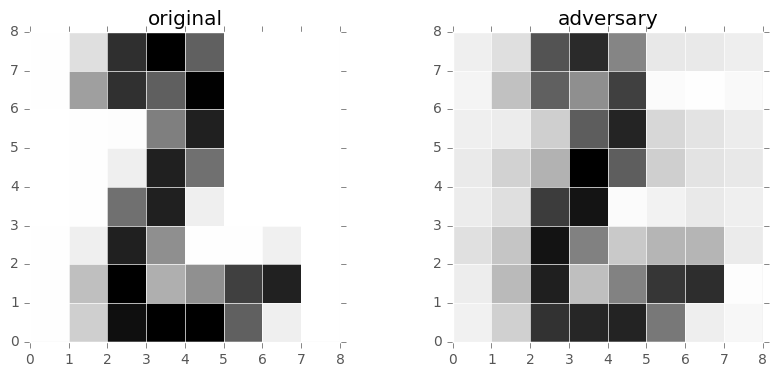

In [37]:
f, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].imshow(-candidate_image, cmap='gray', interpolation='none',  extent=[0, x_width, 0, x_height])
axs[0].set_title('original')

axs[1].imshow(-adversarial_image, cmap='gray', interpolation='none',  extent=[0, x_width, 0, x_height])
axs[1].set_title('adversary')
plt.show()